loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


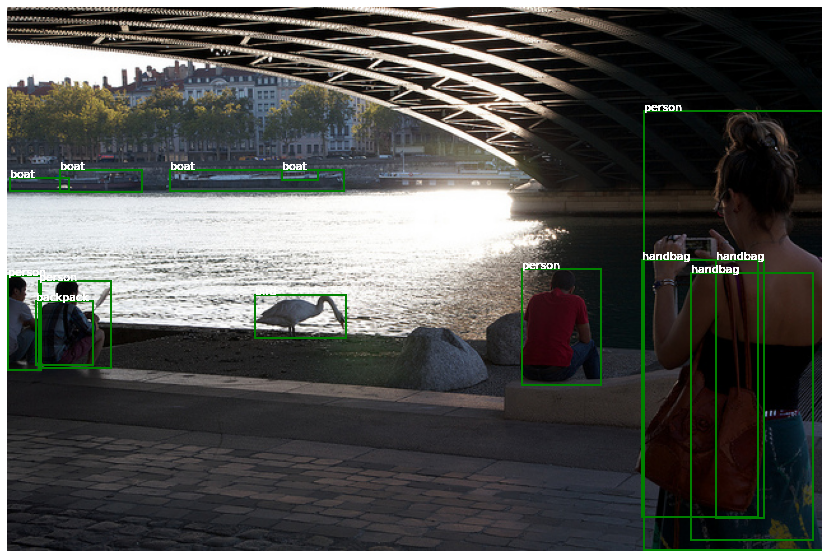



Detected  person  with score:  0.998
Detected  handbag  with score:  0.997
Detected  bird  with score:  0.996
Detected  person  with score:  0.992
Detected  person  with score:  0.990
Detected  person  with score:  0.988
Detected  boat  with score:  0.962
Detected  handbag  with score:  0.889
Detected  boat  with score:  0.829
Detected  handbag  with score:  0.818
Detected  backpack  with score:  0.674
Detected  boat  with score:  0.629
Detected  boat  with score:  0.620
(Detected?  handbag  with score:  0.254)
(Detected?  bench  with score:  0.241)
(Detected?  boat  with score:  0.219)
(Detected?  boat  with score:  0.195)
(Detected?  car  with score:  0.183)
(Detected?  handbag  with score:  0.152)
(Detected?  person  with score:  0.149)
(Detected?  boat  with score:  0.112)
(Detected?  handbag  with score:  0.096)
(Detected?  backpack  with score:  0.087)
(Detected?  handbag  with score:  0.085)
(Detected?  couch  with score:  0.084)
(Detected?  boat  with score:  0.080)
(Detected

In [2]:
#First try on Object Detection using a pre-trained model on the COCO dataset.
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import torch
import matplotlib.pyplot as plt

#Load the pre-trained model on COCO 2017
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
#model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

#Download the COCO test dataset
if os.path.isfile("./val2017.zip") == False: 
  !wget "http://images.cocodataset.org/zips/val2017.zip"
  !unzip "./val2017.zip"
  
if os.path.isfile("./annotations_trainval2017.zip") == False:  
  !wget "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
  !unzip "./annotations_trainval2017.zip"

#Import the test images of the dataset
cocoDataset = datasets.CocoDetection(root="./val2017", 
                                     annFile="./annotations/instances_val2017.json",
                                     transform=transforms.ToTensor())
  
#cocoDataset_test = DataLoader(cocoDataset, batch_size=1000, shuffle=True)

def showImageFromDataset(imageNumber):
  #Take only the image tensor from the dataset
  imgTensor = cocoDataset[imageNumber][0]

  #Tensor -> PIL image transformation
  transToPIL = transforms.ToPILImage(mode='RGB')
  imgPIL = transToPIL(imgTensor.squeeze())

  #Show the image
  plt.imshow(imgPIL)
  plt.show()

def showImageWithDetection(imageNumber, modelOutput, threshold):

  #Take only the image tensor from the dataset
  imgTensor = cocoDataset[imageNumber][0]

  #Tensor -> PIL image transformation
  transToPIL = transforms.ToPILImage(mode='RGB')
  imgPIL = transToPIL(imgTensor.squeeze())

  #Extract the targets values from the list of tensors
  boxes  = [d['boxes']  for d in modelOutput]
  labels = [d['labels'] for d in modelOutput]
  scores = [d['scores'] for d in modelOutput]  

  #print(torch.numel(boxes[0])/4) #Just to check

  #Output classes of the COCO dataset
  COCO_CATEGORY_NAMES = [ 
  'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
  'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
  'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
  'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
  'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
  'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
  'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
  'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
  'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
  'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
  'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
  'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
  ]

  #Show the image with the bounding boxes (rectangles)
  plt.figure(figsize=(20,10))
  plt.imshow(imgPIL)
  plt.axis("off")

  numBoxes = int(torch.numel(boxes[0])/4)

  for i in range(numBoxes):
    #Apply a threshold to the score in order to have less but better predictions
    for i in range(torch.numel(scores[0])): #numel(scores[0])=numel(labels[0])=numel(boxes[0])/4
      if scores[0][i] > threshold:
        rect = plt.Rectangle((boxes[0][i][0], boxes[0][i][1]),
                              boxes[0][i][2] - boxes[0][i][0],
                              boxes[0][i][3] - boxes[0][i][1], fill=False,
                              edgecolor="g", linewidth=2)
        plt.gca().add_patch(rect)

        #Add the category of the detected
        plt.gca().text(boxes[0][i][0], boxes[0][i][1],COCO_CATEGORY_NAMES[labels[0][i]],
                      color='white',fontsize=11)

  plt.show()

  #Print the accuracy for each prediction 
  print('\n') 
  for i in range(numBoxes):
    obj = COCO_CATEGORY_NAMES[labels[0][i]]

    #Apply a threshold to distinguish between certain and less good detections
    if scores[0][i] > threshold:      
      print('{:s} {:s} {:s} {:.3f}'.format('Detected ', obj, ' with score: ',scores[0][i]))
    else:
      print('{:s} {:s} {:s} {:.3f}{:s}'.format('(Detected? ', obj, ' with score: ',scores[0][i],')'))


def testModel(model, imageNumber, device):
  model.eval()

  with torch.no_grad(): #Without computing the gradients (just testing)

    imgTensor = cocoDataset[imageNumber][0]    
    imgTensor = imgTensor.to(device)
        
    output = model(imgTensor.unsqueeze_(0)) #Model output   
    #print(output) #Just to check  

  return output

#Select one image from the COCO testing dataset
imageToTest = 10

#Show the "raw" image
#showImageFromDataset(imageToTest) 

#Call the testModel function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output = testModel(model, imageToTest, device)

#Show the results given the image and the model output
threshold = 0.5 #Set a minimum value of the certainty about the prediction
showImageWithDetection(imageToTest,output,threshold)


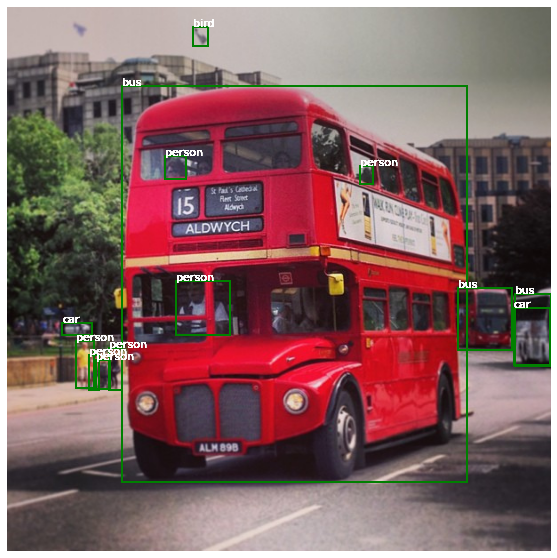



Detected  bus  with score:  1.000
Detected  bus  with score:  0.996
Detected  person  with score:  0.987
Detected  person  with score:  0.980
Detected  person  with score:  0.980
Detected  bird  with score:  0.919
Detected  person  with score:  0.914
Detected  person  with score:  0.877
Detected  bus  with score:  0.863
Detected  person  with score:  0.836
Detected  person  with score:  0.790
Detected  car  with score:  0.621
Detected  car  with score:  0.561
(Detected?  person  with score:  0.383)
(Detected?  person  with score:  0.317)
(Detected?  person  with score:  0.316)
(Detected?  truck  with score:  0.273)
(Detected?  person  with score:  0.258)
(Detected?  bicycle  with score:  0.255)
(Detected?  person  with score:  0.236)
(Detected?  person  with score:  0.223)
(Detected?  person  with score:  0.201)
(Detected?  bicycle  with score:  0.188)
(Detected?  person  with score:  0.185)
(Detected?  handbag  with score:  0.180)
(Detected?  person  with score:  0.166)
(Detected?  

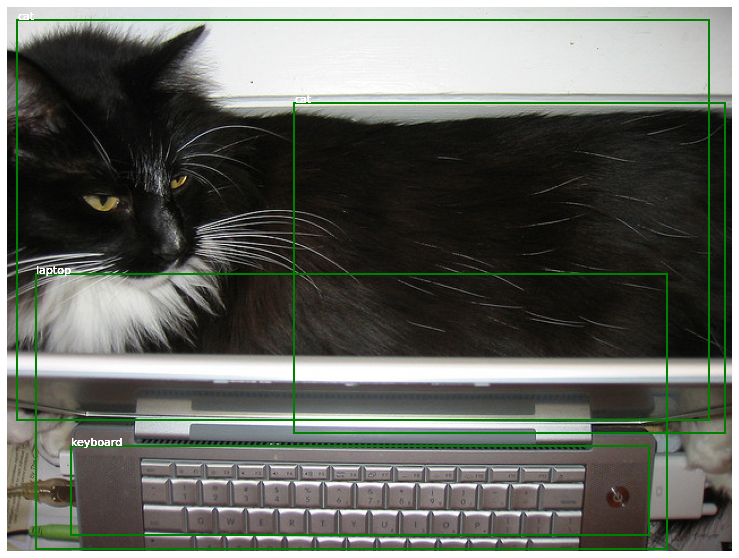



Detected  cat  with score:  0.980
Detected  keyboard  with score:  0.790
Detected  laptop  with score:  0.784
Detected  cat  with score:  0.611
(Detected?  laptop  with score:  0.438)
(Detected?  keyboard  with score:  0.170)
(Detected?  tv  with score:  0.147)
(Detected?  bed  with score:  0.083)
(Detected?  cat  with score:  0.069)


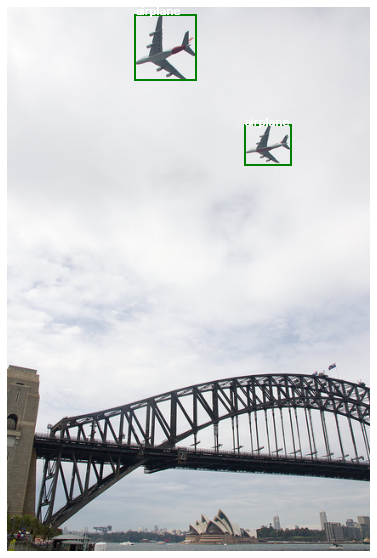



Detected  airplane  with score:  0.999
Detected  airplane  with score:  0.999
(Detected?  truck  with score:  0.498)
(Detected?  car  with score:  0.408)
(Detected?  kite  with score:  0.309)
(Detected?  car  with score:  0.190)
(Detected?  truck  with score:  0.063)


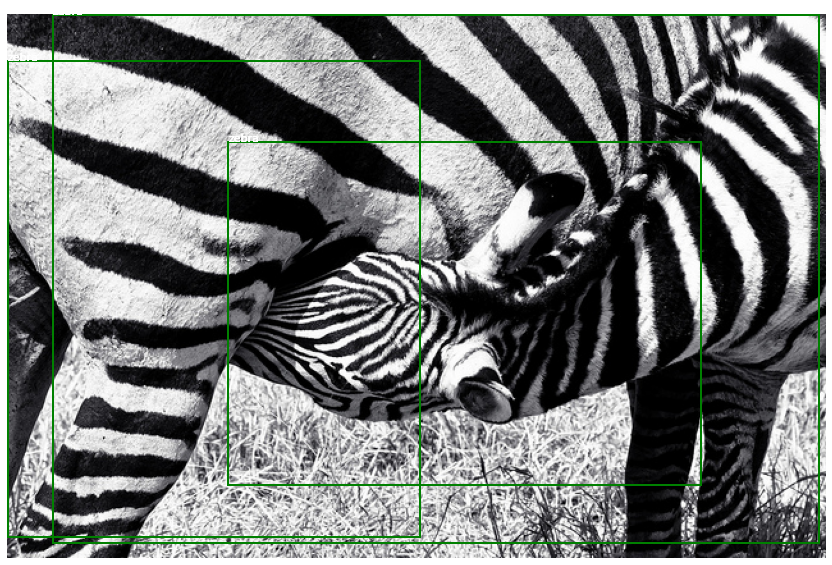



Detected  zebra  with score:  0.994
Detected  zebra  with score:  0.709
Detected  zebra  with score:  0.682
(Detected?  zebra  with score:  0.230)
(Detected?  zebra  with score:  0.057)
(Detected?  zebra  with score:  0.053)


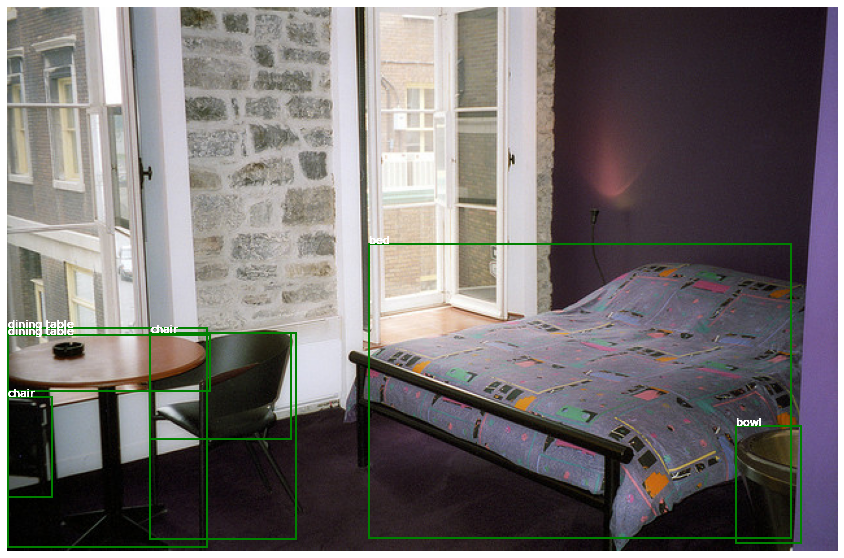



Detected  chair  with score:  0.997
Detected  dining table  with score:  0.970
Detected  bed  with score:  0.958
Detected  dining table  with score:  0.759
Detected  bowl  with score:  0.740
Detected  chair  with score:  0.541
Detected  chair  with score:  0.525
(Detected?  bowl  with score:  0.383)
(Detected?  dining table  with score:  0.164)
(Detected?  chair  with score:  0.114)
(Detected?  remote  with score:  0.087)
(Detected?  couch  with score:  0.086)
(Detected?  chair  with score:  0.068)
(Detected?  dining table  with score:  0.061)
(Detected?  dining table  with score:  0.060)
(Detected?  cell phone  with score:  0.054)
(Detected?  clock  with score:  0.051)


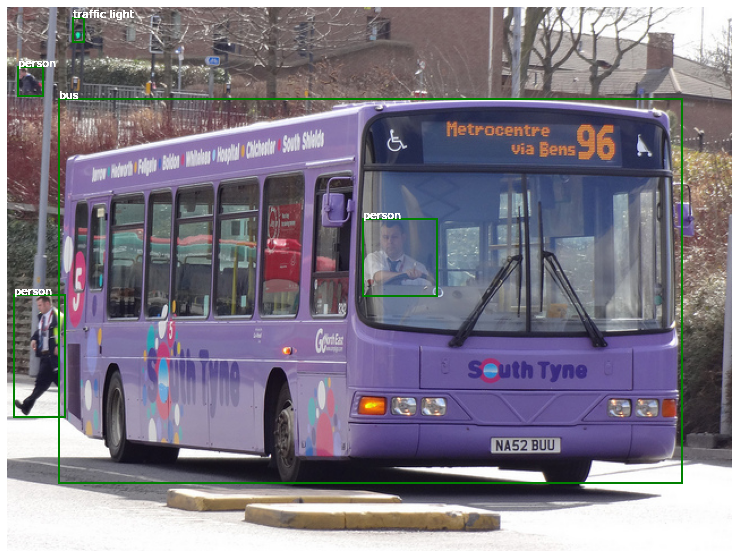



Detected  bus  with score:  1.000
Detected  person  with score:  0.998
Detected  person  with score:  0.996
Detected  person  with score:  0.970
Detected  traffic light  with score:  0.804
(Detected?  traffic light  with score:  0.418)
(Detected?  traffic light  with score:  0.395)
(Detected?  chair  with score:  0.277)
(Detected?  chair  with score:  0.256)
(Detected?  tie  with score:  0.236)
(Detected?  traffic light  with score:  0.233)
(Detected?  traffic light  with score:  0.192)
(Detected?  traffic light  with score:  0.187)
(Detected?  person  with score:  0.147)
(Detected?  bottle  with score:  0.129)
(Detected?  handbag  with score:  0.119)
(Detected?  handbag  with score:  0.094)
(Detected?  tie  with score:  0.081)
(Detected?  person  with score:  0.079)
(Detected?  traffic light  with score:  0.076)
(Detected?  handbag  with score:  0.069)
(Detected?  handbag  with score:  0.065)
(Detected?  handbag  with score:  0.060)
(Detected?  handbag  with score:  0.060)
(Detected

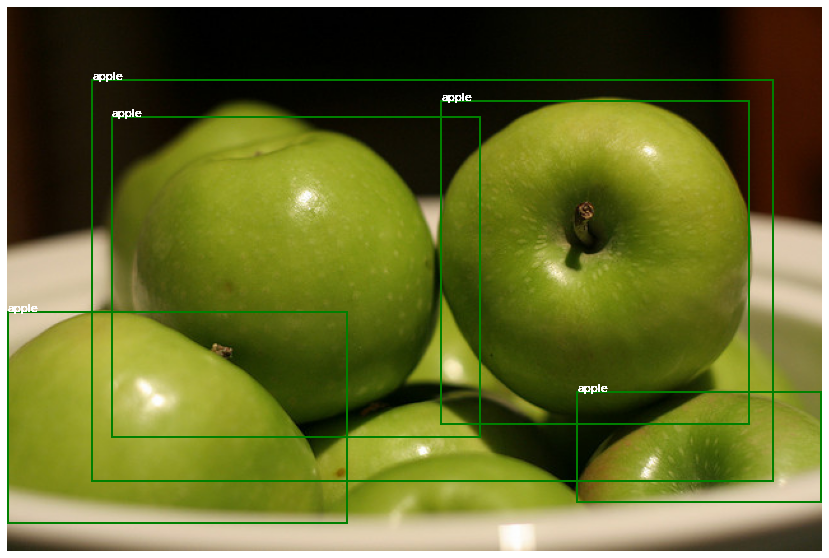



Detected  apple  with score:  0.975
Detected  apple  with score:  0.975
Detected  apple  with score:  0.911
Detected  apple  with score:  0.794
Detected  apple  with score:  0.593
(Detected?  apple  with score:  0.392)
(Detected?  banana  with score:  0.339)
(Detected?  banana  with score:  0.332)
(Detected?  bowl  with score:  0.311)
(Detected?  bowl  with score:  0.201)
(Detected?  apple  with score:  0.185)
(Detected?  apple  with score:  0.147)
(Detected?  apple  with score:  0.145)
(Detected?  orange  with score:  0.139)
(Detected?  apple  with score:  0.124)
(Detected?  banana  with score:  0.114)
(Detected?  bowl  with score:  0.103)
(Detected?  apple  with score:  0.099)
(Detected?  apple  with score:  0.079)
(Detected?  apple  with score:  0.079)
(Detected?  orange  with score:  0.072)
(Detected?  apple  with score:  0.066)


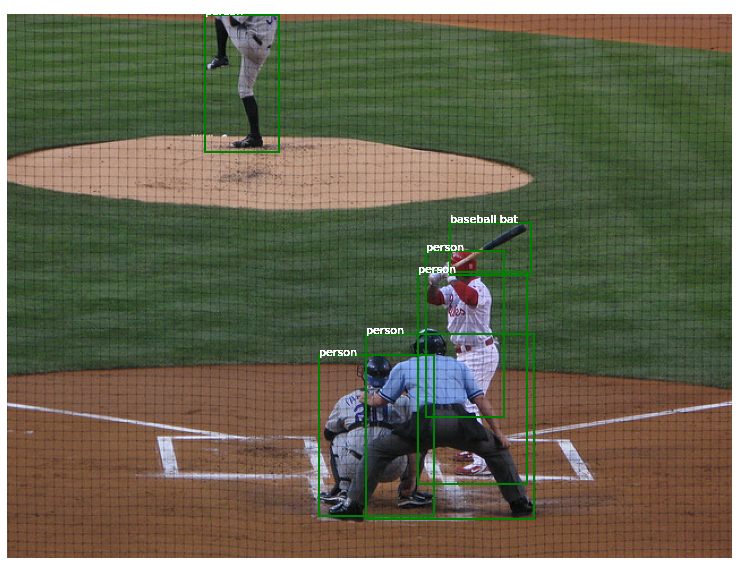



Detected  person  with score:  0.999
Detected  person  with score:  0.996
Detected  person  with score:  0.990
Detected  baseball bat  with score:  0.987
Detected  person  with score:  0.984
Detected  person  with score:  0.959
(Detected?  baseball glove  with score:  0.413)
(Detected?  person  with score:  0.212)
(Detected?  baseball glove  with score:  0.210)
(Detected?  person  with score:  0.205)
(Detected?  person  with score:  0.204)
(Detected?  person  with score:  0.132)
(Detected?  sports ball  with score:  0.113)
(Detected?  baseball glove  with score:  0.088)
(Detected?  person  with score:  0.071)
(Detected?  baseball glove  with score:  0.065)
(Detected?  baseball glove  with score:  0.050)
(Detected?  person  with score:  0.050)


In [3]:
#Select several images from the COCO testing dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for imageToTest in range(17,25):
  #Call the testModel function  
  output = testModel(model, imageToTest, device) 
  #Set a minimum value % of the prediction certainty
  threshold = 0.5 
  #Show the results
  showImageWithDetection(imageToTest,output,threshold) 